In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

### Load the dataset

In [2]:
file_path = 'processed_dataset_v3.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,sentence,emotion,Tokens,POS_Tags_new,Sentiment_Score_new,GloVe_Embedding_new
0,That game hurt.,sadness,"['that', 'game', 'hurt', '.']","['DET', 'NOUN', 'VERB', 'PUNCT']",-0.5267,"[-0.18378876149654388, 0.21825924515724182, -0..."
1,"You do right, if you don't care then fuck 'em!",neutral,"['you', 'do', 'right', ',', 'if', 'you', 'do',...","['PRON', 'VERB', 'NOUN', 'PUNCT', 'SCONJ', 'PR...",0.1316,"[-0.13493569195270538, 0.12419985234737396, -0..."
2,Man I love reddit.,happiness,"['man', 'i', 'love', 'reddit', '.']","['NOUN', 'PRON', 'VERB', 'PROPN', 'PUNCT']",0.6369,"[-0.0781317949295044, 0.17847399413585663, -0...."
3,"Etenia was nowhere near them, he was by the Fa...",neutral,"['etenia', 'was', 'nowhere', 'near', 'them', '...","['PROPN', 'AUX', 'ADV', 'ADP', 'PRON', 'PUNCT'...",0.0000,"[0.02850472740828991, 0.07425817847251892, -0...."
4,Right? Considering it's such an important docu...,happiness,"['right', '?', 'considering', 'it', ""'s"", 'suc...","['INTJ', 'PUNCT', 'VERB', 'PRON', 'AUX', 'DET'...",0.6239,"[-0.029261890798807144, 0.11021193861961365, -..."


### Downsample the classes with most data points - (Happinness and Sadness)

In [4]:
# Define target undersampled sizes
target_sizes = {
    "happiness": 100_000,
    "sadness": 80_000
}

# Separate out the DataFrame per emotion
dfs = []
# for loop to iterate through the unique emotions in the DataFrame
for emotion in df["emotion"].unique():
    subset = df[df["emotion"] == emotion]
    # check if the current emotion is in the target sizes
    if emotion in target_sizes:
        # Undersample with random_state for reproducibility
        subset = subset.sample(n=target_sizes[emotion], random_state=42)
    
    dfs.append(subset)

# Combine back all subsets
balanced_df = pd.concat(dfs).reset_index(drop=True)

# Shuffle the final DataFrame
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("New class distribution:\n", df["emotion"].value_counts())

New class distribution:
 emotion
happiness    100000
sadness       80000
anger         67216
fear          49008
neutral       32910
surprise      23598
disgust        6531
Name: count, dtype: int64


### Pre-Process the Tokens with max length for padding set to 50

In [5]:
import ast
#  Safe converter for Tokens column 
def safe_tokens_to_str(x):
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)  # Convert stringified list to real list
        except:
            return ""
    if isinstance(x, list):
        return ' '.join(x)  # Join list to space-separated string
    return ""

# Apply clean conversion 
df['Tokens_str'] = df['Tokens'].apply(safe_tokens_to_str)

# Tokenization 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Tokens_str'])
sequences = tokenizer.texts_to_sequences(df['Tokens_str'])

# Padding
max_len = 50
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

### Check the length of words distribution

In [6]:
import ast

df["Tokens"] = df["Tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["seq_len"] = df["Tokens"].apply(len)

# Summary statistics
print("🔍 Sequence length stats:")
print(df["seq_len"].describe())

🔍 Sequence length stats:
count    359263.000000
mean         18.311691
std          10.637971
min           0.000000
25%          10.000000
50%          16.000000
75%          24.000000
max         179.000000
Name: seq_len, dtype: float64


### Pre-Process the Pos Tags

In [7]:
# encode the labels
df['POS_Tags_new'] = df['POS_Tags_new'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# flatten the list of lists to get all unique tags
all_tags = [tag for seq in df['POS_Tags_new'] for tag in seq]
# initialize the label encoder and fit it on the unique tags
le_pos = LabelEncoder()
le_pos.fit(all_tags)
# create a new column with the encoded labels
df['POS_Encoded'] = df['POS_Tags_new'].apply(lambda tags: le_pos.transform(tags))
pos_padded = pad_sequences(df['POS_Encoded'], maxlen=max_len, padding='post')

### Pre-Process the Sentiment Score

In [8]:
# initialize the one-hot encoder
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(df[['Sentiment_Score_new']])

### Pre-Process the Glove Embeddings (Sentence Averaged)

In [9]:
# PreProcess GloVe embeddings
df['GloVe_Embedding_new'] = df['GloVe_Embedding_new'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.zeros(300))
# Vstack the GloVe embeddings
glove_features = np.vstack(df['GloVe_Embedding_new'].values)

### Pre-Process the labels using label encoder

In [10]:
# initialize label encoder
label_encoder = LabelEncoder()
# fit the label encoder on the unique labels
int_labels = label_encoder.fit_transform(df['emotion'])
# convert the labels to a one-hot encoded format
onehot_encoder = OneHotEncoder(sparse_output=False)
labels = onehot_encoder.fit_transform(int_labels.reshape(-1, 1))

### Train/Val split the dataset and the feature to prepare for training

In [11]:
# Define the input features and labels
X_text = padded_sequences
X_pos = pos_padded
X_sentiment = sentiment_scaled
X_glove = glove_features
y = labels


# Set validation split percentage
val_size = 0.2  # 20% of the data for validation

# Perform train-validation split
X_train_text, X_val_text, \
X_train_pos, X_val_pos, \
X_train_sent, X_val_sent, \
X_train_glove, X_val_glove, \
y_train, y_val = train_test_split(
    X_text, X_pos, X_sentiment, X_glove, y,
    test_size=val_size, random_state=42, stratify=y
)

# Print dataset sizes
print(f"Train Samples: {len(X_train_text)}")
print(f"Validation Samples: {len(X_val_text)}")

Train Samples: 287410
Validation Samples: 71853


### Define class-weights, so there is more attention to the less represented classes

In [12]:
#  Get label counts again
class_counts = {
    "happiness": 168071,
    "sadness": 129437,
    "anger": 67216,
    "fear": 49008,
    "neutral": 28223,
    "surprise": 19525,
    "disgust": 1750,  
}

# Compute initial class weights
total_samples = sum(class_counts.values())
class_weights = {label: total_samples / (len(class_counts) * count) for label, count in class_counts.items()}

# Fine-Tune Class-Weights Manually
class_weights["disgust"] *= 0.8   
class_weights["happiness"] *= 1.2  
class_weights["sadness"] *= 1.15   
class_weights["anger"] *= 1.1      
class_weights["neutral"] *= 1.0    
class_weights["surprise"] *= 1.0  
class_weights["fear"] *= 1.0       

# Convert to Keras format
label_encoder = LabelEncoder()
# Fit the label encoder on the unique labels
int_labels = label_encoder.fit_transform(list(class_counts.keys()))
class_weight_dict = {int_labels[i]: class_weights[label] for i, label in enumerate(class_counts.keys())}

print("Adjusted Class Weights:", class_weight_dict)

Adjusted Class Weights: {3: 0.4724839927343631, 5: 0.5879468114107359, 0: 1.0829755670418608, 2: 1.3503043234923744, 4: 2.3447441549698573, 6: 3.3892811413938175, 1: 30.251755102040818}


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.regularizers import l2

# Define the required constants
MAX_SEQUENCE_LENGTH = 50  # based on your padding length
VOCAB_SIZE = len(tokenizer.word_index) + 1  # +1 for padding token
POS_DIM = pos_padded.shape[1]  # Should be same as MAX_SEQUENCE_LENGTH
NUM_CLASSES = labels.shape[1]  # Number of emotion categories (7)
POS_TAGS = np.unique(np.concatenate(df['POS_Encoded'].values)).tolist()  # all unique encoded tags
NUM_POS_TAGS = len(POS_TAGS)

def build_emotion_classifier():
    # Text input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
    embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=300, input_length=MAX_SEQUENCE_LENGTH)(text_input)
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
    lstm_layer = Bidirectional(LSTM(32))(lstm_layer)
    
    # Sentiment input
    sentiment_input = Input(shape=(1,), name='sentiment_input')
    
    # POS input (one-hot or frequency vector assumed)
    pos_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='pos_input')
    pos_dense = Dense(16, activation='relu')(pos_input)
    
    # GloVe embedding input (precomputed 300-dim sentence vector)
    glove_input = Input(shape=(300,), name='glove_input')
    glove_dense = Dense(50, activation='relu')(glove_input)
    
    # Merge all features
    merged = Concatenate()([lstm_layer, sentiment_input, pos_dense, glove_dense])
    
    # Dense layers
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
    dropout = Dropout(0.3)(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout)
    dropout = Dropout(0.2)(dense)
    
    # Output
    emotion_output = Dense(NUM_CLASSES, activation='softmax', name='emotion_output')(dropout)
    
    # Compile model
    model = Model(
        inputs=[text_input, sentiment_input, pos_input, glove_input],
        outputs=emotion_output
    )
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [14]:
model = build_emotion_classifier()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      21105000    ['text_input[0][0]']             
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 128)      186880      ['embedding[0][0]']              
                                                                                                  
 pos_input (InputLayer)         [(None, 50)]         0           []                               
                                                                                              

In [15]:
import tensorflow.keras.backend as K
import tensorflow as tf
# define custom metrics
def f1_micro(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### Compile the model and train it on the features

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_micro])
# fit the model and store the training history
history = model.fit(
    x={
        'text_input': X_train_text, # input for text data
        'pos_input': X_train_pos, # input for POS tags
        'sentiment_input': X_train_sent, # input for sentiment score
        'glove_input': X_train_glove # input for Word2Vec embeddings
    },
    y=y_train, # target labels
    # validation data for evaluation during training
    validation_data=(
        {
            'text_input': X_val_text,
            'pos_input': X_val_pos,
            'sentiment_input': X_val_sent,
            'glove_input': X_val_glove
        },
        y_val
    ),
    # define batch size and number of epochs
    batch_size=64,
    epochs=10,
    # use class weights to handle class imbalance
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
4491/4491 [==============================] - 306s 66ms/step - loss: 1.3936 - accuracy: 0.6782 - f1_micro: 0.5685 - val_loss: 0.5923 - val_accuracy: 0.8422 - val_f1_micro: 0.7679
Epoch 2/10
4491/4491 [==============================] - 291s 65ms/step - loss: 0.7566 - accuracy: 0.8429 - f1_micro: 0.7675 - val_loss: 0.4866 - val_accuracy: 0.8586 - val_f1_micro: 0.7869
Epoch 3/10
4491/4491 [==============================] - 301s 67ms/step - loss: 0.6496 - accuracy: 0.8554 - f1_micro: 0.7847 - val_loss: 0.5179 - val_accuracy: 0.8473 - val_f1_micro: 0.7637
Epoch 4/10
4491/4491 [==============================] - 229s 51ms/step - loss: 0.5763 - accuracy: 0.8642 - f1_micro: 0.7967 - val_loss: 0.5165 - val_accuracy: 0.8503 - val_f1_micro: 0.7691
Epoch 5/10
4491/4491 [==============================] - 292s 65ms/step - loss: 0.5125 - accuracy: 0.8722 - f1_micro: 0.8080 - val_loss: 0.5059 - val_accuracy: 0.8501 - val_f1_micro: 0.7690
Epoch 6/10
4491/4491 [==============================] -

In [17]:
model.save("LSTM_model_6.h5")

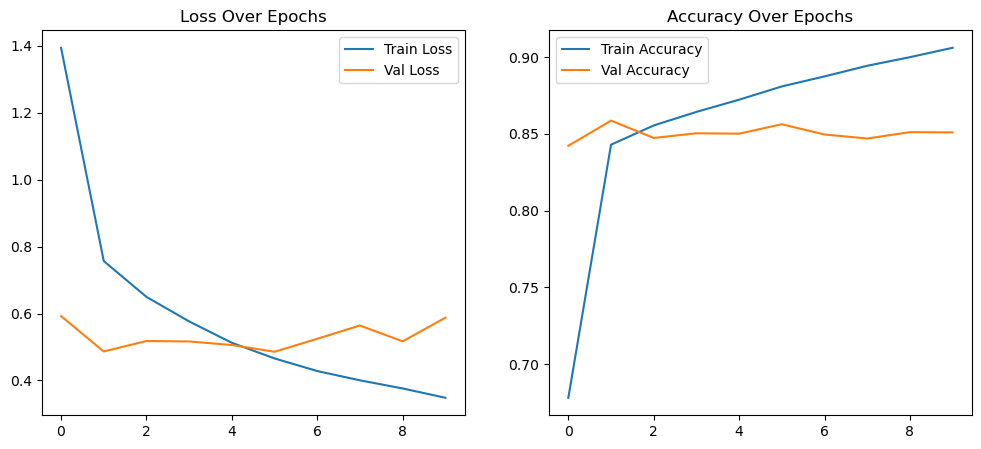

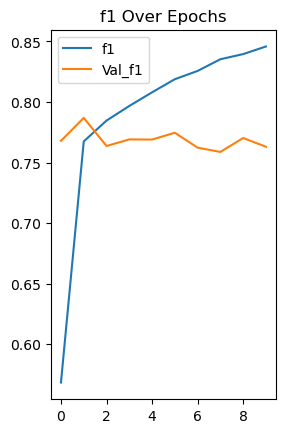

In [18]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()
# plot f1 score
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_micro'], label='f1')
plt.plot(history.history['val_f1_micro'], label='Val_f1')
plt.legend()
plt.title("f1 Over Epochs")
plt.show()

### Confusion Marrix 

In [20]:
import numpy as np

# Get predictions
y_pred_probs = model.predict({
    'text_input': X_val_text,
    'sentiment_input': X_val_sent,
    'pos_input': X_val_pos,
    'glove_input': X_val_glove
})

# Convert from probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


2246/2246 [==============================] - 26s 11ms/step


<Figure size 1000x800 with 0 Axes>

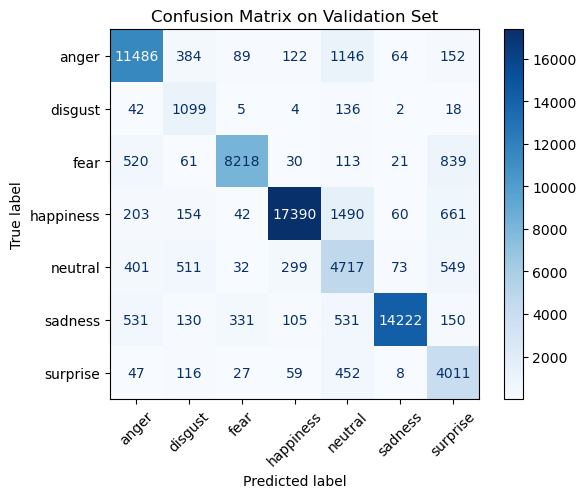

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get emotion label names back from the one-hot encoder
emotion_labels = label_encoder.classes_

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [22]:
from sklearn.metrics import classification_report

# Get label names
emotion_labels = label_encoder.classes_

# Print classification report
report = classification_report(y_true, y_pred, target_names=emotion_labels)
print(report)


              precision    recall  f1-score   support

       anger       0.87      0.85      0.86     13443
     disgust       0.45      0.84      0.58      1306
        fear       0.94      0.84      0.89      9802
   happiness       0.97      0.87      0.92     20000
     neutral       0.55      0.72      0.62      6582
     sadness       0.98      0.89      0.93     16000
    surprise       0.63      0.85      0.72      4720

    accuracy                           0.85     71853
   macro avg       0.77      0.84      0.79     71853
weighted avg       0.88      0.85      0.86     71853

